## Notebook to reproduce the plots that guided the analysis and discovery of using Biopython for reconstruction

In [70]:
import os
import json

from Bio.PDB import PDBParser

# the lines below hide neverending warnings from biopython
import warnings
from Bio.PDB.PDBExceptions import PDBConstructionWarning
from Bio import BiopythonDeprecationWarning
warnings.simplefilter('ignore', PDBConstructionWarning)
warnings.simplefilter('ignore', BiopythonDeprecationWarning)

In [71]:
parser = PDBParser()
structure = parser.get_structure('path/to/pdb/file')

In [74]:
# test the biopython internal_coords module, to see if I can use it to reconstruct full residues

# first, understand how internal coordinates are structured per type of residue
# are they different for every residue?


# chain = next(structure.get_chains())
# print(chain)

structure.atom_to_internal_coordinates()


r1 = next(structure.get_residues())

print(r1)
print(dir(r1.internal_coord))
print(r1.internal_coord.get_angle('N:CA:C'))


<Residue SER het=  resseq=139 icode= >
['NCaCKey', '_AllBonds', '__annotations__', '__class__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_atom', '_b', '_bAll', '_bChi', '_bClass', '_bClassB', '_build_rak_cache', '_create_edra', '_default_startpos', '_do_bond_rotate', '_gen_edra', '_get_ak_tuple', '_get_angle_for_tuple', '_get_startpos', '_link_dihedra', '_pdb_atom_string', '_pfDef', '_relative_atom_re', '_residue_string', '_write_PIC', '_write_pic_bfac', 'accept_atoms', 'accept_backbone', 'accept_deuteriums', 'accept_hydrogens', 'accept_mainchain', 'accept_resnames', 'accept_sidechain', 'ak_set', 'akc', 'alt_ids', 'applyMtx', 'assemble', 'atom_chain', 'atom_sernum', 'bfactors', 'b

In [75]:
# strip all sidechains

THE20 = {'ALA': 0, 'ARG': 1, 'ASN': 2, 'ASP': 3, 'CYS': 4, 'GLN': 5,\
         'GLU': 6, 'GLY': 7, 'HIS': 8, 'ILE': 9, 'LEU': 10, 'LYS': 11,\
         'MET': 12, 'PHE': 13, 'PRO': 14, 'SER': 15, 'THR': 16,\
         'TRP': 17, 'TYR': 18, 'VAL': 19}

from Bio.PDB import PDBParser, PDBIO, Selection, Atom
from Bio.PDB.StructureBuilder import StructureBuilder

def remove_sidechain(residue):
    atoms_to_detach = []
    for atom in residue:
        if atom.id not in {'N', 'CA', 'C', 'O'}:
            atoms_to_detach.append(atom.id)
    for atom_id in atoms_to_detach:
        residue.detach_child(atom_id)

def remove_all_sidechains(structure, inplace=False):

    if not inplace:
        bb_only_structure = structure.copy()
    else:
        bb_only_structure = structure

    for residue in Selection.unfold_entities(bb_only_structure, 'R'):
        if residue.resname in THE20:
            remove_sidechain(residue)
        
    return bb_only_structure

structure = parser.get_structure("pdbs/1aox.pdb", "pdbs/1aox.pdb")

bb_only_structure = remove_all_sidechains(structure)

# io = PDBIO()
# io.set_structure(bb_only_structure)
# io.save("2uwd_bb_only.pdb")

# # importantly, the original PDB structure is not changed, if "inplace" is set to False
# io = PDBIO()
# io.set_structure(structure)
# io.save("2uwd_copy.pdb")

In [76]:
# can reset the resnames at will!

new_structure = structure.copy()

for model in new_structure:
    for chain in model:
        for residue in chain:
            residue.resname = 'XXX'

io = PDBIO()
io.set_structure(new_structure)
io.save("2uwd_copy.pdb")


In [93]:
## add a sidechain at a particular location given the internal coordinates

BB_ATOMS = ['C', 'CA', 'N', 'O']

SIDE_CHAINS = {'MET': ['CB', 'CE', 'CG', 'SD'],
               'ILE': ['CB', 'CD1', 'CG1', 'CG2'],
               'LEU': ['CB', 'CD1', 'CD2', 'CG'],
               'VAL': ['CB', 'CG1', 'CG2'],
               'THR': ['CB', 'CG2', 'OG1'],
               'GLY': [],
               'ALA': ['CB'],
               'ARG': ['CB', 'CD', 'CG', 'CZ', 'NE', 'NH1', 'NH2'],
               'SER': ['CB', 'OG'],
               'LYS': ['CB', 'CD', 'CE', 'CG', 'NZ'],
               'HIS': ['CB', 'CD2', 'CE1', 'CG', 'ND1', 'NE2'],
               'GLU': ['CB', 'CD', 'CG', 'OE1', 'OE2'],
               'ASP': ['CB', 'CG', 'OD1', 'OD2'],
               'PRO': ['CB', 'CD', 'CG'],
               'GLN': ['CB', 'CD', 'CG', 'NE2', 'OE1'],
               'TYR': ['CB', 'CD1', 'CD2', 'CE1', 'CE2', 'CG', 'CZ', 'OH'],
               'TRP': ['CB', 'CD1', 'CD2', 'CE2', 'CE3', 'CG', 'CH2', 'CZ2', 'CZ3', 'NE1'],
               'CYS': ['CB', 'SG'],
               'ASN': ['CB', 'CG', 'ND2', 'OD1'],
               'PHE': ['CB', 'CD1', 'CD2', 'CE1', 'CE2', 'CG', 'CZ']}

CHI_ANGLES = {
    'ARG' : [['N','CA','CB','CG'], ['CA','CB','CG','CD'], ['CB','CG','CD','NE'], ['CG','CD','NE','CZ']], #, ['CD','NE','CZ','NH1']],
    'ASN' : [['N','CA','CB','CG'], ['CA','CB','CG','OD1']],
    'ASP' : [['N','CA','CB','CG'], ['CA','CB','CG','OD1']],
    'CYS' : [['N','CA','CB','SG']],
    'GLN' : [['N','CA','CB','CG'], ['CA','CB','CG','CD'], ['CB','CG','CD','OE1']],
    'GLU' : [['N','CA','CB','CG'], ['CA','CB','CG','CD'], ['CB','CG','CD','OE1']],
    'HIS' : [['N','CA','CB','CG'], ['CA', 'CB','CG','ND1']],
    'ILE' : [['N','CA','CB','CG1'], ['CA','CB','CG1','CD1']],
    'LEU' : [['N','CA','CB','CG'], ['CA','CB','CG','CD1']],
    'LYS' : [['N','CA','CB','CG'], ['CA','CB','CG','CD'], ['CB','CG','CD','CE'], ['CG','CD','CE','NZ']],
    'MET' : [['N','CA','CB','CG'], ['CA','CB','CG','SD'], ['CB','CG','SD','CE']],
    'PHE' : [['N','CA','CB','CG'], ['CA','CB','CG','CD1']],
    'PRO' : [['N','CA','CB','CG'], ['CA','CB','CG','CD']],
    'SER' : [['N','CA','CB','OG']],
    'THR' : [['N','CA','CB','OG1']],
    'TRP' : [['N','CA','CB','CG'], ['CA','CB','CG','CD1']],
    'TYR' : [['N','CA','CB','CG'], ['CA','CB','CG','CD1']],
    'VAL' : [['N','CA','CB','CG1']]
}

def all_permutations(atomic_combo):
    import itertools
    return list(map(lambda x: ':'.join(x), list(itertools.permutations(atomic_combo.split(':')))))

def is_only_backbone(atomic_combo):
    return all(map(lambda x: x in BB_ATOMS, atomic_combo.split(':')))

def is_only_backbone_and_CB(atomic_combo):
    return all(map(lambda x: x in BB_ATOMS + ['CB'], atomic_combo.split(':')))

def all_possible_atomic_combos(resname, num_atoms):
    import itertools
    return list(map(lambda x: ':'.join(x), list(itertools.combinations(BB_ATOMS + SIDE_CHAINS[resname], num_atoms))))

def only_has_backbone_and_CB_but_shouldnt(residue):
    '''
    Catches the case in which the residue does not appear to have sidechain atoms for some reason
    '''
    if residue.resname in {'GLY', 'ALA'}: return False
    
    for atom in residue.get_atoms():
        if atom.id not in {'N', 'CA', 'C', 'O', 'CB'}:
            return False
    return True


def remove_chi_angle_atomic_combos(residue, internal_coords):
    '''
    If the atomic_combo is a chi angle, substitute the chi angle name
    '''
    if residue.resname in {'GLY', 'ALA'}: return internal_coords

    atomic_combos = list(internal_coords.keys())
    for i, chi_angle in enumerate(CHI_ANGLES[residue.resname]):
        for perm in all_permutations(':'.join(chi_angle)):
            if perm in atomic_combos:
                del internal_coords[perm]
    return internal_coords


def get_internal_coords_from_scratch(residue, get_backbone=True):

    internal_coords = {}
    for atomic_combo in all_possible_atomic_combos(residue.resname, 2):
        if not is_only_backbone(atomic_combo) or get_backbone:
            for perm in all_permutations(atomic_combo):
                value = residue.internal_coord.get_length(perm)
                if value is not None:
                    internal_coords[perm] = value
                    break

    for atomic_combo in all_possible_atomic_combos(residue.resname, 3):
        if not is_only_backbone(atomic_combo) or get_backbone:
            for perm in all_permutations(atomic_combo):
                value = residue.internal_coord.get_angle(perm)
                if value is not None:
                    internal_coords[perm] = value
                    break
    
    for atomic_combo in all_possible_atomic_combos(residue.resname, 4):
        if not is_only_backbone(atomic_combo) or get_backbone:
            for perm in all_permutations(atomic_combo):
                value = residue.internal_coord.get_angle(perm)
                if value is not None:
                    internal_coords[perm] = value
                    break
    
    for i in range(1, 5):
        value = residue.internal_coord.get_angle(f'chi{i}')
        if value is not None:
            internal_coords[f'chi{i}'] = value
    
    internal_coords = remove_chi_angle_atomic_combos(residue, internal_coords)
    
    return internal_coords


def get_internal_coords_from_precomputed_keys(residue, internal_coords_atomic_combos, verbose=False):

    internal_coords = {}
    for atomic_combo in internal_coords_atomic_combos:
        if len(atomic_combo.split(':')) == 2:
            value = residue.internal_coord.get_length(atomic_combo)
        elif len(atomic_combo.split(':')) in {3, 4} or 'chi' in atomic_combo:
            value = residue.internal_coord.get_angle(atomic_combo)
        else:
            raise ValueError(f'Atomic combo {atomic_combo} is not of length 2, 3, or 4')
        
        if value is None and verbose:
            print(f'Warning, None encountered for {atomic_combo} in {residue.full_id} - {residue.resname}')
        
        internal_coords[atomic_combo] = value
    
    return internal_coords

def get_internal_coords_for_pdbs(pdb_list, pdbdir, internal_coords_atomic_combos):
    from Bio.PDB import PDBParser
    from tqdm import tqdm
    parser = PDBParser()

    internal_coords_trace = {resname: {} for resname in internal_coords_atomic_combos.keys()}

    for pdb in tqdm(pdb_list):
        structure = parser.get_structure(pdb, os.path.join(pdbdir, f'{pdb}.pdb'))
        structure.atom_to_internal_coordinates()

        for residue in Selection.unfold_entities(structure, 'R'):
            if residue.resname in THE20:
                if not only_has_backbone_and_CB_but_shouldnt(residue):
                    try:
                        internal_coords = get_internal_coords_from_precomputed_keys(residue, internal_coords_atomic_combos[residue.resname], verbose=False)
                    except AttributeError:
                        # sometimes the reisdue.internal_coord is None, for some reason
                        print('Warning, residue.internal_coord is None for', residue.full_id, residue.resname)
                        continue

                    if None in internal_coords.values(): # faulty residue that is missing some internal coords
                        continue

                    for atomic_combo in internal_coords:
                        if atomic_combo not in internal_coords_trace[residue.resname]:
                            internal_coords_trace[residue.resname][atomic_combo] = []
                        internal_coords_trace[residue.resname][atomic_combo].append(internal_coords[atomic_combo])
    
    return internal_coords_trace
        


def add_atom(residue, atom_name, coord):
    # dummy values follow DLPacker
    # NOTE: we might have to artificially remove altloc? though idk I think pyrosetta handles it automatically
    # pyrosetta does automatically handle occupancy (it just keeps the highest occupancy)
    atom = Atom.Atom(atom_name,
                        coord,
                        0, # dummy bfactor
                        1, # dummy occupancy
                        ' ', # dummy altloc
                        atom_name, # we put fullname in without spaces because who cares anyway
                        2, # dummy serial number
                        element = atom_name[:1]) # for protein atoms, this is always true!
    residue.add(atom)



In [165]:
import warnings
warnings.simplefilter('ignore', RuntimeWarning)

SIDE_CHAINS = {'MET': ['CB', 'CE', 'CG', 'SD'],
               'ILE': ['CB', 'CD1', 'CG1', 'CG2'],
               'LEU': ['CB', 'CD1', 'CD2', 'CG'],
               'VAL': ['CB', 'CG1', 'CG2'],
               'THR': ['CB', 'CG2', 'OG1'],
               'GLY': [],
               'ALA': ['CB'],
               'ARG': ['CB', 'CD', 'CG', 'CZ', 'NE', 'NH1', 'NH2'],
               'SER': ['CB', 'OG'],
               'LYS': ['CB', 'CD', 'CE', 'CG', 'NZ'],
               'HIS': ['CB', 'CD2', 'CE1', 'CG', 'ND1', 'NE2'],
               'GLU': ['CB', 'CD', 'CG', 'OE1', 'OE2'],
               'ASP': ['CB', 'CG', 'OD1', 'OD2'],
               'PRO': ['CB', 'CD', 'CG'],
               'GLN': ['CB', 'CD', 'CG', 'NE2', 'OE1'],
               'TYR': ['CB', 'CD1', 'CD2', 'CE1', 'CE2', 'CG', 'CZ', 'OH'],
               'TRP': ['CB', 'CD1', 'CD2', 'CE2', 'CE3', 'CG', 'CH2', 'CZ2', 'CZ3', 'NE1'],
               'CYS': ['CB', 'SG'],
               'ASN': ['CB', 'CG', 'ND2', 'OD1'],
               'PHE': ['CB', 'CD1', 'CD2', 'CE1', 'CE2', 'CG', 'CZ']}

def print_coords(residue):
    for atom in residue:
        print(atom.name, atom.coord)

def add_all_atoms(structure):
    for residue in Selection.unfold_entities(structure, 'R'):
        if residue.resname in THE20:
            CA_COORDS = residue['CA'].coord + np.array([1, 1, 1])
            for atom_name in SIDE_CHAINS[residue.resname]:
                add_atom(residue, atom_name, CA_COORDS)

def _align_residues(residue1, residue2):
    # Aligns two residues using backbone atoms
    from Bio.PDB import Superimposer
    sup = Superimposer()
    bb_a, bb_b = [], []
    for n in BB_ATOMS:
        if residue1.has_id(n) and residue2.has_id(n):
            bb_a.append(residue1[n])
            bb_b.append(residue2[n])
            
    sup.set_atoms(bb_a, bb_b)
    sup.apply(residue2)



def _align_structures(structure_a, structure_b):
    # Aligns two structures using backbone atoms
    from Bio.PDB import Superimposer
    sup = Superimposer()
    bb_a, bb_b = [], []
    residues_a = Selection.unfold_entities(structure_a, 'R')
    residues_b = Selection.unfold_entities(structure_b, 'R')
    for a, b in zip(residues_a, residues_b):
        for n in BB_ATOMS:
            if a.has_id(n):
                bb_a.append(a[n])
                bb_b.append(b[n])
                
    sup.set_atoms(bb_a, bb_b)
    sup.apply(structure_b)

structure = parser.get_structure("pdbs/1aox.pdb", "pdbs/1aox.pdb")


bb_only_structure = remove_all_sidechains(structure, inplace=False)
add_all_atoms(bb_only_structure)

structure.atom_to_internal_coordinates(verbose=True)

bb_only_structure.atom_to_internal_coordinates(verbose=False)

residues = structure.get_residues()
bb_only_residues = bb_only_structure.get_residues()

residue = next(residues)
residue_bb_only = next(bb_only_residues)

print(residue.resname, residue.child_dict)
print(residue_bb_only.resname, residue_bb_only.child_dict)
print()

internal_coords = get_internal_coords_from_scratch(residue)
print(internal_coords)

internal_coords_bb_only = get_internal_coords_from_scratch(residue_bb_only)
print(internal_coords_bb_only)

print()

residue_bb_only.internal_coord.set_length('CB:OG', 1.0)
residue_bb_only.internal_coord.set_angle('CA:CB:OG', 120.0)

internal_coords_bb_only = get_internal_coords_from_scratch(residue_bb_only)
print(internal_coords_bb_only)

bb_only_structure.internal_to_atom_coordinates(verbose=True)

print()
print_coords(residue)
print()
structure.internal_to_atom_coordinates(verbose=True)
print_coords(residue)
print()
print_coords(residue_bb_only)

# _align_structures(structure, bb_only_structure)
_align_residues(residue, residue_bb_only)

print()
print_coords(residue)
print()
print_coords(residue_bb_only)


# # add atoms to the bb_only_structure and see if I can get the internal coords to update
# CA_COORDS = residue_bb_only['CA'].coord
# for atom_name in SIDE_CHAINS[residue_bb_only.resname]:
#     add_atom(residue_bb_only, atom_name, CA_COORDS)

# bb_only_structure.internal_coord = None
# bb_only_structure.atom_to_internal_coordinates(verbose=True)

# print_coords(residue_bb_only)
# internal_coords_bb_only = get_internal_coords_from_scratch(residue_bb_only)
# print(internal_coords_bb_only)




# >>> # access the array of all atoms for the chain, e.g. r2 above is residue 152 C-beta
# >>> r2_cBeta_index = myChain.internal_coord.atomArrayIndex[AtomKey("152_D_CB")] # D is for ASP!! the resname. might struggle with changing resnames
# >>> r2_cBeta_coords = myChain.internal_coord.atomArray[r2_cBeta_index]
# >>> print(np.round(r2_cBeta_coords, 2))
# [-0.75 -1.18 -0.51  1.  ]

# >>> # the Biopython Atom coord array is now a view into atomArray, so
# >>> assert r2_cBeta_coords[1] == r2["CB"].coord[1]
# >>> r2_cBeta_coords[1] += 1.0  # change the Y coord 1 angstrom
# >>> assert r2_cBeta_coords[1] == r2["CB"].coord[1]
# >>> # they are always the same (they share the same memory)
# >>> r2_cBeta_coords[1] -= 1.0  # restore

SER {'N': <Atom N>, 'CA': <Atom CA>, 'C': <Atom C>, 'O': <Atom O>, 'CB': <Atom CB>, 'OG': <Atom OG>}
SER {'N': <Atom N>, 'CA': <Atom CA>, 'C': <Atom C>, 'O': <Atom O>, 'CB': <Atom CB>, 'OG': <Atom OG>}

{'C:CA': 1.5310573817631736, 'C:O': 1.2255419132221785, 'CA:N': 1.5040168500337363, 'CA:CB': 1.5410137849784578, 'CB:OG': 1.420127539855465, 'N:CA:C': 109.33662478373323, 'CA:C:O': 120.23738513698078, 'CB:CA:C': 112.03477573926699, 'N:CA:CB': 111.50879632786844, 'CA:CB:OG': 112.71054431822482, 'N:CA:C:O': -12.130030960444627, 'O:C:CA:CB': 112.00931265566577, 'chi1': 58.77241428859858}
{'C:CA': 1.5310573817631736, 'C:O': 1.2255419132221785, 'CA:N': 1.5040168500337363, 'CA:CB': 1.7320508075688772, 'CB:OG': 0.0, 'N:CA:C': 109.33662478373323, 'CA:C:O': 120.23738513698078, 'CB:CA:C': 46.98724432896834, 'N:CA:CB': 110.72786192487129, 'CA:CB:OG': nan, 'N:CA:C:O': -12.130030960444627, 'O:C:CA:CB': -112.82602625335868, 'chi1': 14.036243467926479}

{'C:CA': 1.5310573817631736, 'C:O': 1.2255419132

In [94]:
def precompute_internal_coords_atomic_combos_by_resname(pdbdir):
    import os
    from Bio.PDB import PDBParser
    from tqdm import tqdm

    pdbs = list(filter(lambda x: x.endswith('.pdb'), os.listdir(pdbdir)))[:5]
    parser = PDBParser()

    internal_coords_atomic_combos_by_resname = {aa: set() for aa in THE20}

    for pdb in tqdm(pdbs):

        structure = parser.get_structure(pdb.strip('.pdb'), os.path.join(pdbdir, pdb))
        structure.atom_to_internal_coordinates()

        for residue in Selection.unfold_entities(structure, 'R'):
            if residue.resname in THE20:
                if not only_has_backbone_and_CB_but_shouldnt(residue):
                    # sometimes, some residues miss the some internal coords... idk why, but, in order to avoid missing them here, I will re-compute them for multiple instances
                    # of the same residue, and keep the union of them. we do this for a few pdbs and that should be more than enough

                    internal_coords_atomic_combos_by_resname[residue.resname] = internal_coords_atomic_combos_by_resname[residue.resname].union(set(get_internal_coords_from_scratch(residue).keys()))
    
    for key in internal_coords_atomic_combos_by_resname:
        internal_coords_atomic_combos_by_resname[key] = list(internal_coords_atomic_combos_by_resname[key])
            
    return internal_coords_atomic_combos_by_resname


internal_coords_atomic_combos_by_resname = precompute_internal_coords_atomic_combos_by_resname('./pdbs')

with open('internal_coords_atomic_combos_by_resname.json', 'w') as f:
    json.dump(internal_coords_atomic_combos_by_resname, f, indent=4)

for aa in internal_coords_atomic_combos_by_resname:
    print(aa, internal_coords_atomic_combos_by_resname[aa])


100%|██████████| 5/5 [00:27<00:00,  5.60s/it]

ALA ['CA:C:O', 'N:CA:C', 'N:CA:CB', 'O:C:CA:CB', 'CB:CA:C', 'N:CA:C:O', 'CA:CB', 'CA:N', 'C:CA', 'C:O']
ARG ['chi1', 'CD:NE:CZ:NH2', 'CD:NE:CZ', 'CZ:NH1', 'CB:CA:C', 'CD:NE', 'N:CA:C:O', 'CD:NE:CZ:NH1', 'CZ:NE', 'CZ:NH2', 'chi2', 'chi4', 'CA:N', 'C:CA', 'C:O', 'CA:C:O', 'N:CA:C', 'N:CA:CB', 'CG:CD:NE', 'NE:CZ:NH1', 'CB:CG:CD', 'O:C:CA:CB', 'CD:CG', 'CB:CG', 'CA:CB:CG', 'NE:CZ:NH2', 'CA:CB', 'chi3']
ASN ['chi1', 'CA:CB:CG:ND2', 'CG:ND2', 'CB:CA:C', 'N:CA:C:O', 'CB:CG:OD1', 'chi2', 'CA:N', 'C:CA', 'C:O', 'CG:OD1', 'CA:C:O', 'N:CA:C', 'N:CA:CB', 'O:C:CA:CB', 'CB:CG:ND2', 'CB:CG', 'CA:CB:CG', 'CA:CB']
ASP ['chi1', 'CG:OD2', 'CB:CA:C', 'N:CA:C:O', 'CB:CG:OD1', 'chi2', 'CA:N', 'C:CA', 'C:O', 'CG:OD1', 'CA:C:O', 'N:CA:C', 'N:CA:CB', 'CB:CG:OD2', 'O:C:CA:CB', 'CB:CG', 'CA:CB:CG', 'CA:CB', 'CA:CB:CG:OD2']
CYS ['chi1', 'CA:C:O', 'N:CA:C', 'N:CA:CB', 'CA:CB:SG', 'O:C:CA:CB', 'CB:CA:C', 'N:CA:C:O', 'CA:CB', 'CB:SG', 'CA:N', 'C:CA', 'C:O']
GLN ['CD:OE1', 'CB:CG:CD:NE2', 'chi1', 'CB:CA:C', 'N:CA:C:O

In [95]:
# now let's compute the distribution of each internal coordinate, stsrting with the CB parts, which are the same for every amino-acid

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats.kde import gaussian_kde

with open('internal_coords_atomic_combos_by_resname.json', 'r') as f:
    internal_coords_atomic_combos_by_resname = json.load(f)

with open('pdb_list.txt', 'r') as f:
    pdb_list = f.read().splitlines()
pdbdir = './pdbs'

internal_coords_trace = get_internal_coords_for_pdbs(pdb_list, pdbdir, internal_coords_atomic_combos_by_resname)

 32%|███▏      | 32/100 [00:16<00:43,  1.58it/s]

Warning, residue.internal_coord is None for ('1i1q', 0, 'A', ('H_TRP', 1001, ' ')) TRP


 52%|█████▏    | 52/100 [00:35<00:27,  1.73it/s]

Warning, residue.internal_coord is None for ('2wb9', 0, 'A', ('H_CYS', 301, ' ')) CYS


 57%|█████▋    | 57/100 [00:39<00:29,  1.44it/s]

Warning, residue.internal_coord is None for ('4wx4', 0, 'C', ('H_GLY', 401, ' ')) GLY


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


/var/folders/hj/_3fznhqx3513kg4bkj6hjxw40000gn/T/ipykernel_91449/1492573153.py:23: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


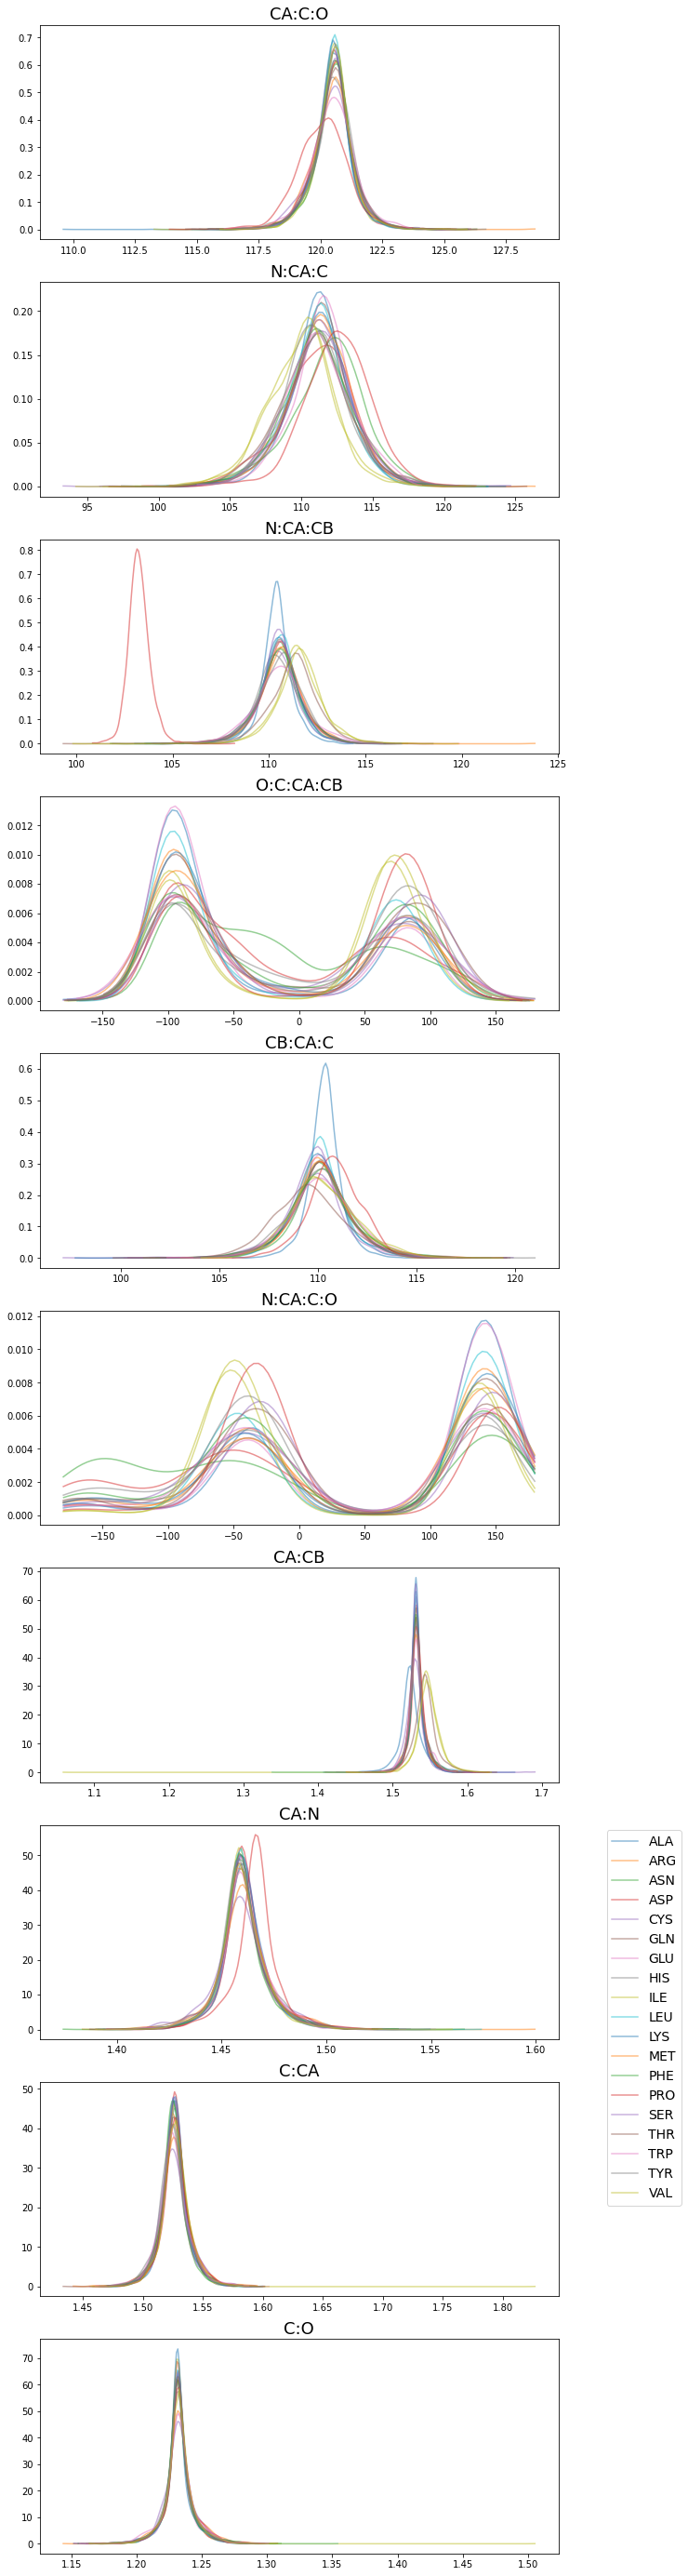

"\nIt looks like O:C:CA:CB usually has a bimodial distribution... ans not a perfect one either. which means we can't just use the mean/median value to place the CB atom.\nUnless... CB:CA:C and C:CA:CB \n"

In [96]:
# Plotting CB parameters

CB_atomic_combos = internal_coords_atomic_combos_by_resname['ALA']

ncols = 1
nrows = len(CB_atomic_combos)
colsize = 10
rowsize = 5
fig, axs = plt.subplots(figsize=(ncols*colsize, nrows*rowsize), ncols=ncols, nrows=nrows, sharex=False, sharey=False)


for i, CB_atomic_combo in enumerate(CB_atomic_combos):
    for aa in internal_coords_trace:
        if aa == 'GLY': continue
        kde = gaussian_kde(internal_coords_trace[aa][CB_atomic_combo])
        x = np.linspace(np.min(internal_coords_trace[aa][CB_atomic_combo]), np.max(internal_coords_trace[aa][CB_atomic_combo]), 100)
        axs[i].plot(x, kde(x), alpha=.5, label=aa)
    
    axs[i].set_title(CB_atomic_combo, fontsize=18)
    

plt.legend(fontsize=14, loc="right",bbox_to_anchor=(1.25, 2.5))
plt.tight_layout()
plt.show()


'''
It looks like O:C:CA:CB usually has a bimodial distribution... ans not a perfect one either. which means we can't just use the mean/median value to place the CB atom.
Unless... CB:CA:C and C:CA:CB 
'''

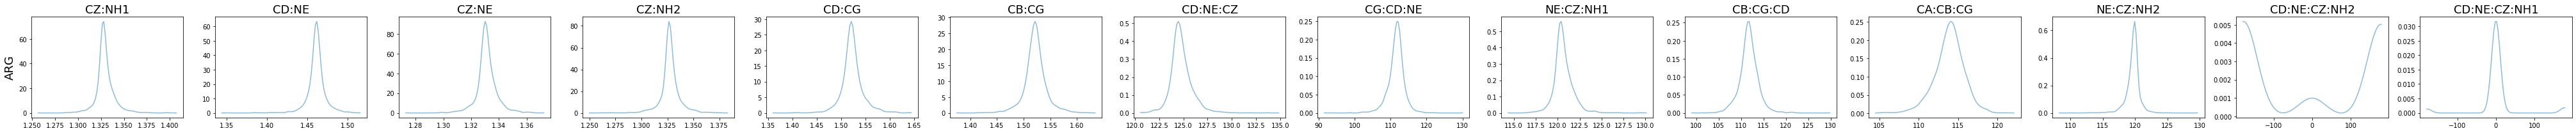

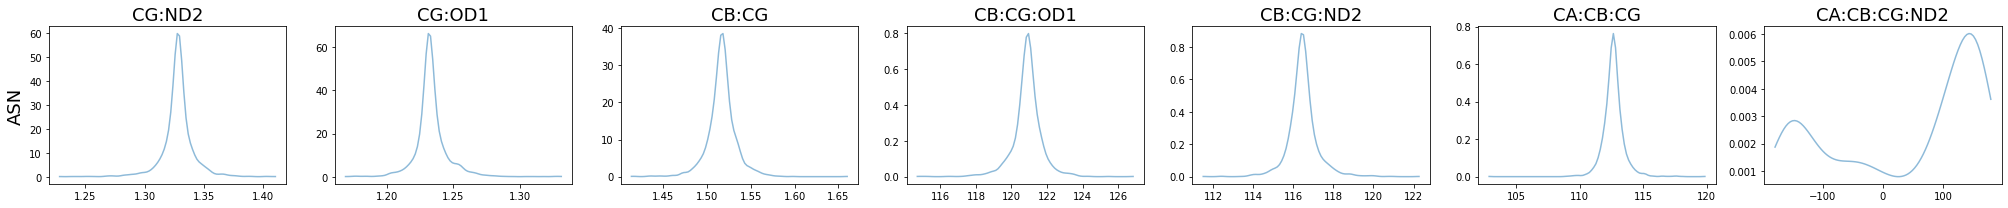

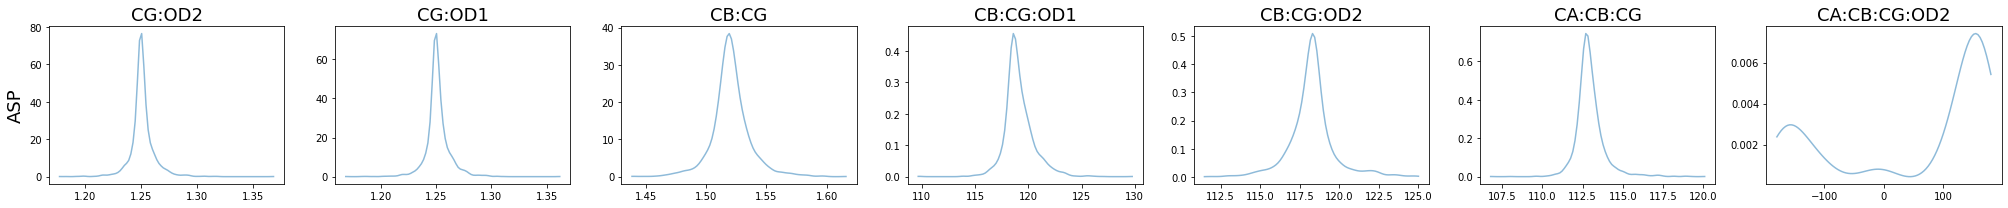

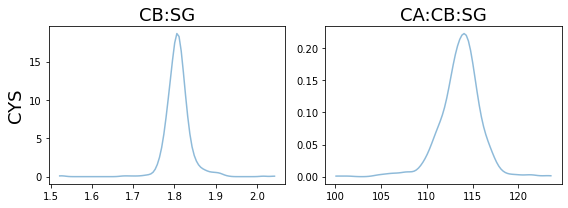

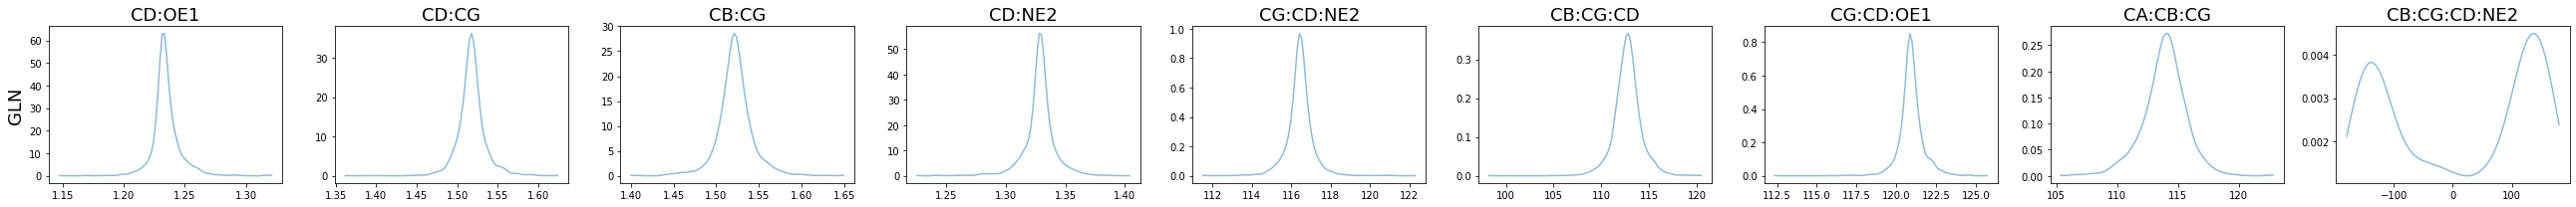

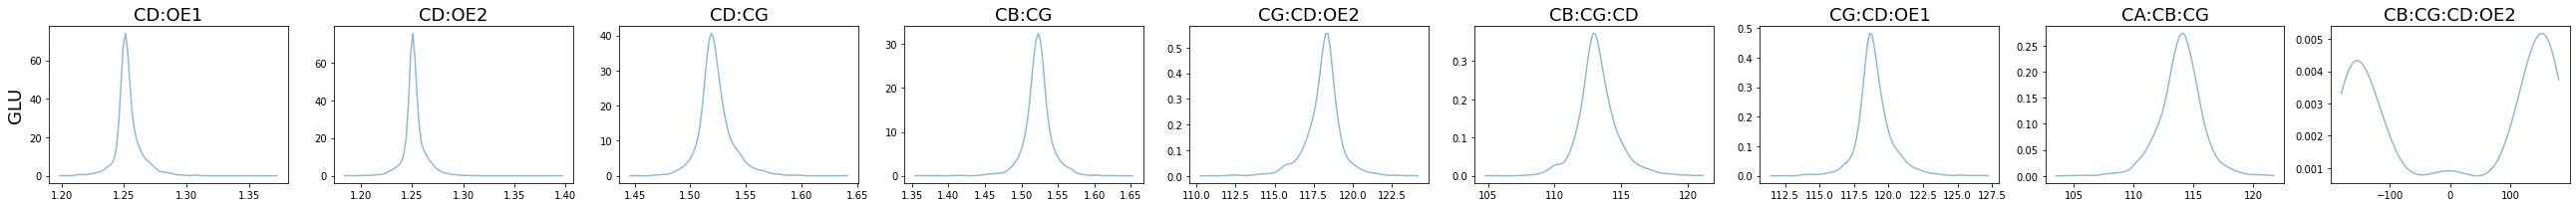

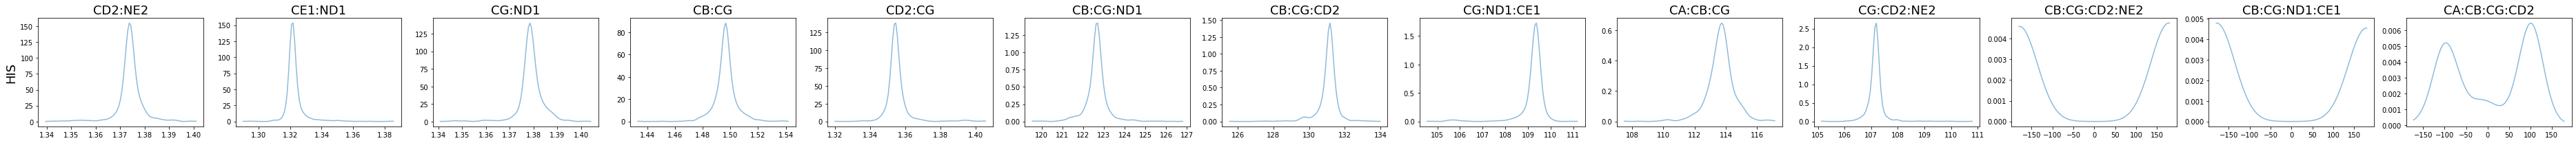

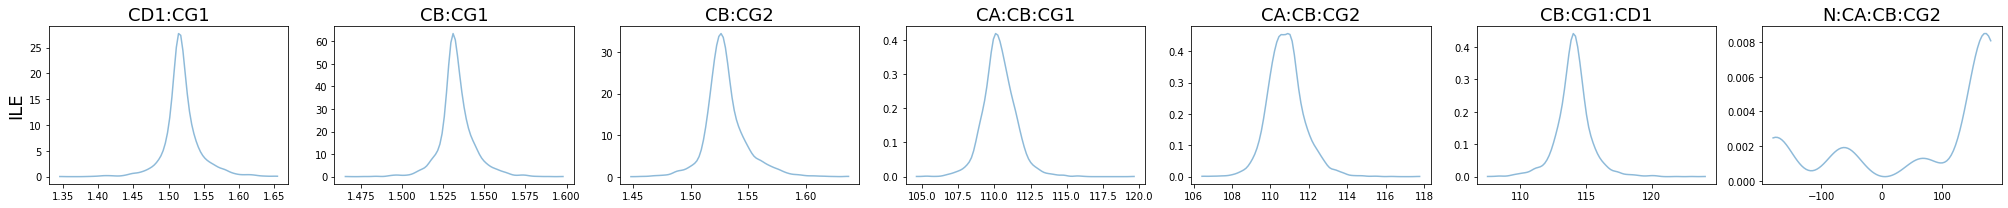

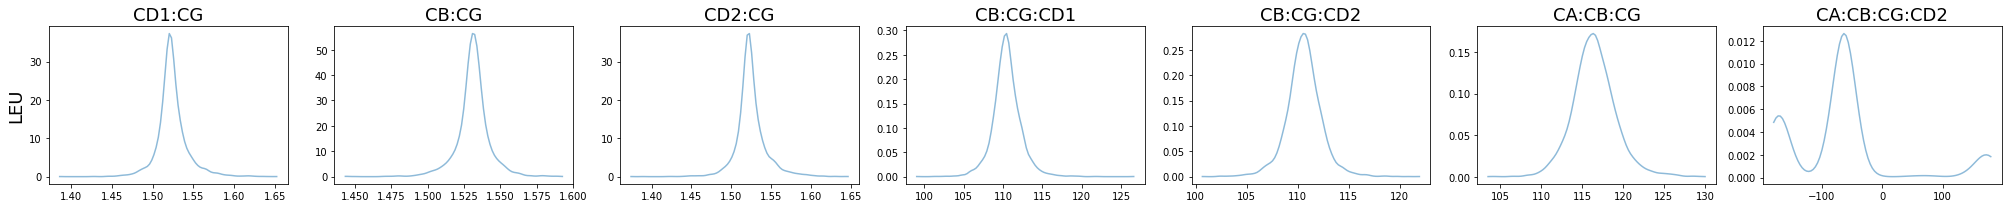

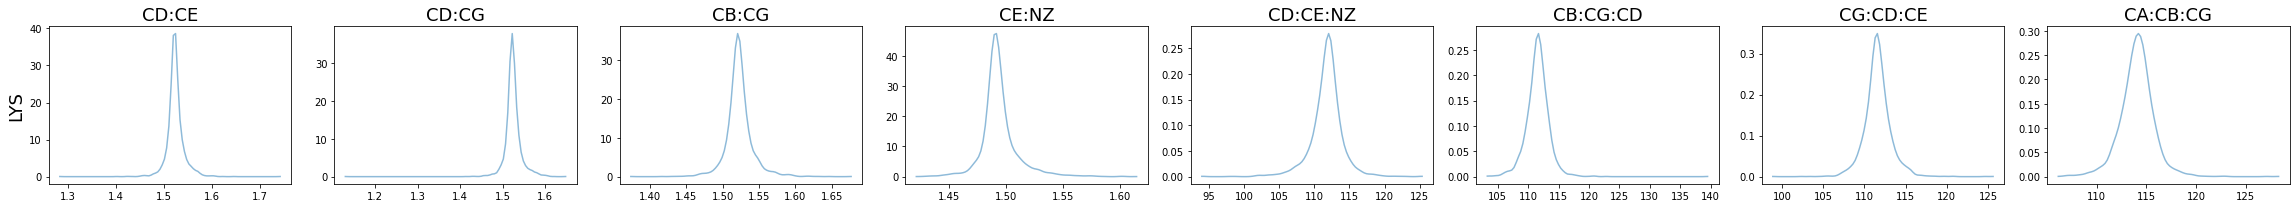

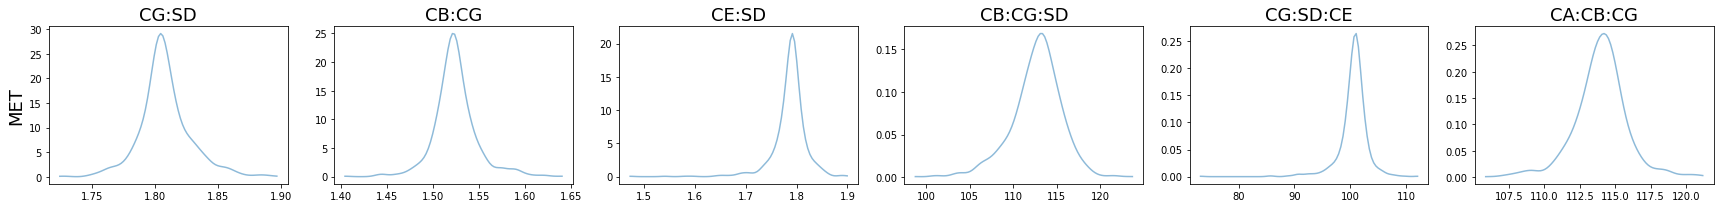

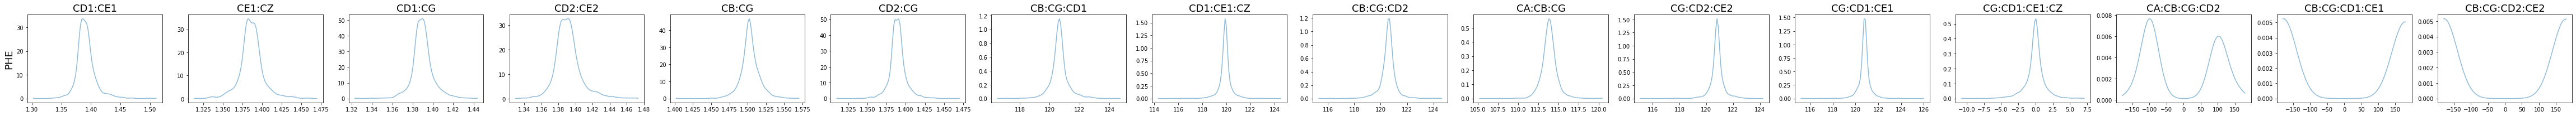

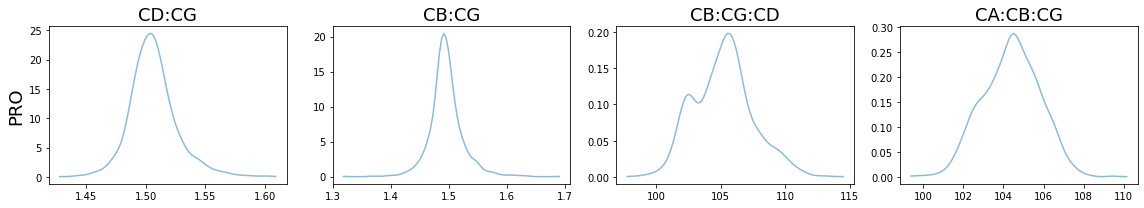

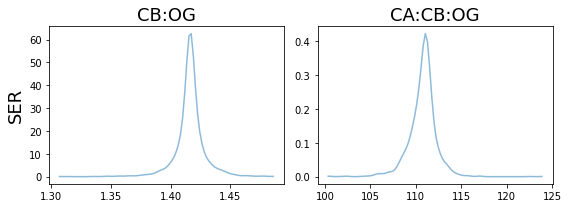

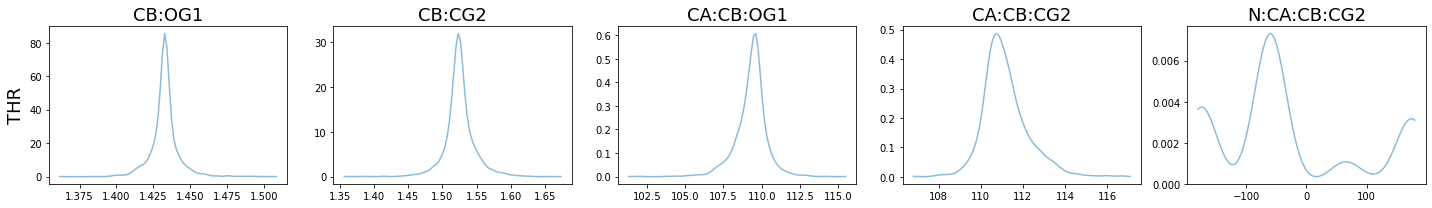

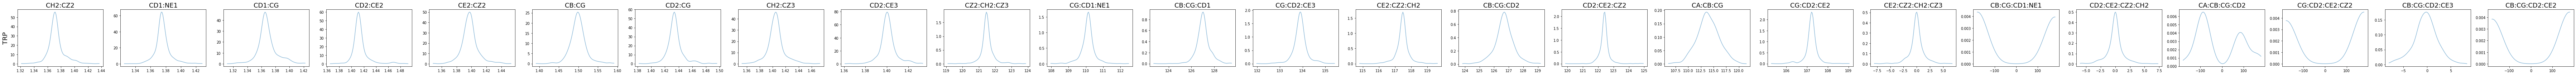

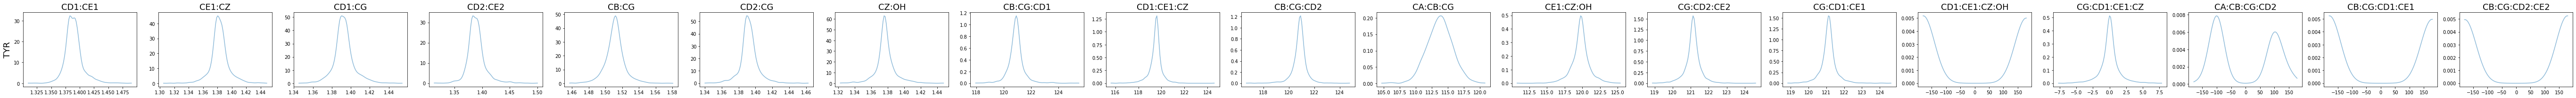

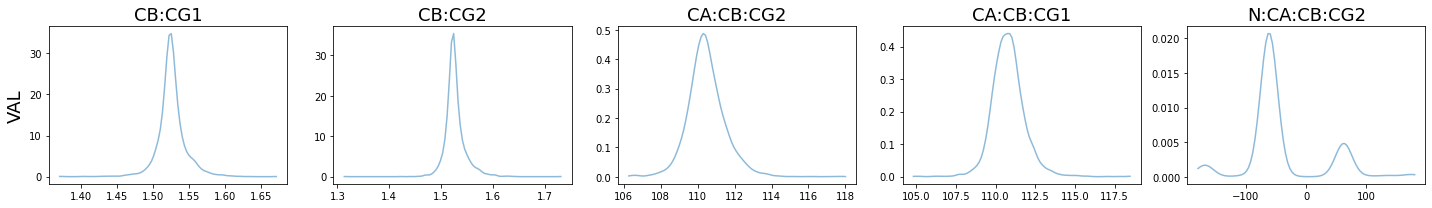

In [105]:
# Plot all of the non-backbone and non-CB atomic combos, for each amino-acid... see about their distributions. We want all of them to just be gaussian

def plots_atomic_combo_distributions_for_side_chains(internal_coords_trace, internal_coords_atomic_combos_by_resname, types_of_combos=['bond lengths', 'bond angles', 'dihedral angles']):

    for type_of_combos in types_of_combos:
        assert type_of_combos in {'bond lengths', 'bond angles', 'dihedral angles'}

    for aa in internal_coords_atomic_combos_by_resname:
        if aa in {'GLY', 'ALA'}: continue

        # only keep sidechain atomic combos, ignore chi angles, and sort them in the following order: bond lengths - bond angles - dihedral angles

        atomic_combos = list(filter(lambda x: not is_only_backbone_and_CB(x) and 'chi' not in x, internal_coords_atomic_combos_by_resname[aa]))

        bond_lengths = list(filter(lambda x: len(x.split(':')) == 2, atomic_combos))
        bond_angles = list(filter(lambda x: len(x.split(':')) == 3, atomic_combos))
        dihedral_angles = list(filter(lambda x: len(x.split(':')) == 4, atomic_combos))

        atomic_combos = []
        for type_of_combos in types_of_combos:
            if type_of_combos == 'bond lengths':
                atomic_combos += bond_lengths
            elif type_of_combos == 'bond angles':
                atomic_combos += bond_angles
            elif type_of_combos == 'dihedral angles':
                atomic_combos += dihedral_angles

        atomic_combos.sort(key=lambda x: len(x.split(':')))

        if len(atomic_combos) == 0: continue

        ncols = len(atomic_combos)
        nrows = 1
        colsize = 4
        rowsize = 3
        fig, axs = plt.subplots(figsize=(ncols*colsize, nrows*rowsize), ncols=ncols, nrows=nrows, sharex=False, sharey=False)

        if len(atomic_combos) == 1:
            axs = [axs]
        else:
            axs = axs.flatten()
        
        for i, (atomic_combo, ax) in enumerate(zip(atomic_combos, axs)):
            kde = gaussian_kde(internal_coords_trace[aa][atomic_combo])
            x = np.linspace(np.min(internal_coords_trace[aa][atomic_combo]), np.max(internal_coords_trace[aa][atomic_combo]), 100)
            ax.plot(x, kde(x), alpha=.5)
            ax.set_title(atomic_combo, fontsize=18)
            if i == 0: ax.set_ylabel(aa, fontsize=18)

        plt.tight_layout()
        plt.show()

plots_atomic_combo_distributions_for_side_chains(internal_coords_trace, internal_coords_atomic_combos_by_resname, types_of_combos=['bond lengths', 'bond angles', 'dihedral angles'])


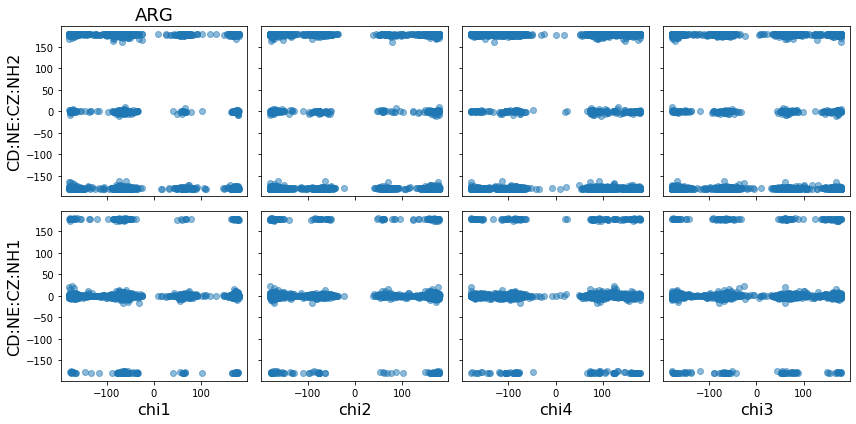

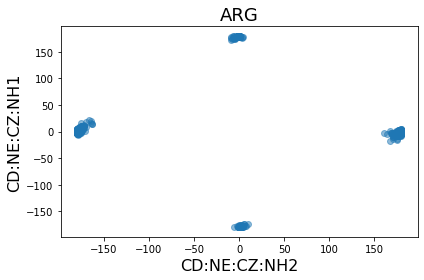

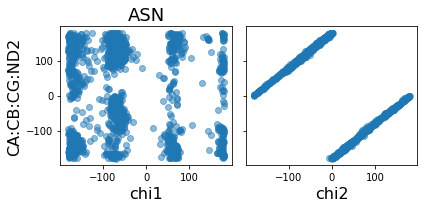

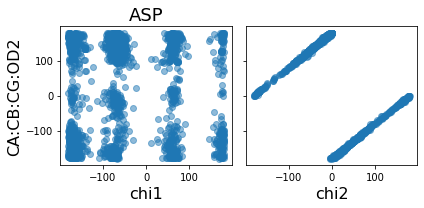

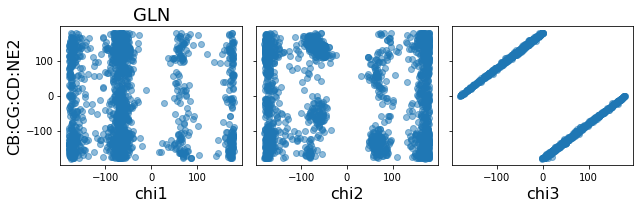

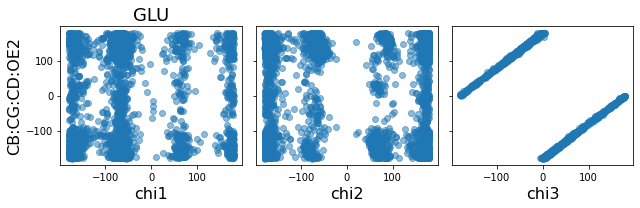

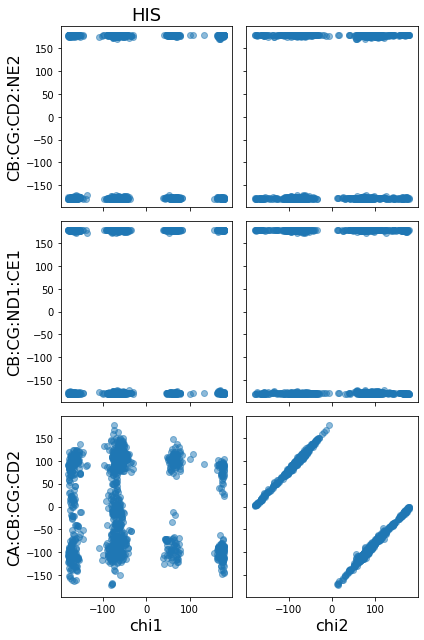

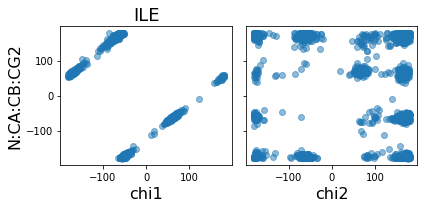

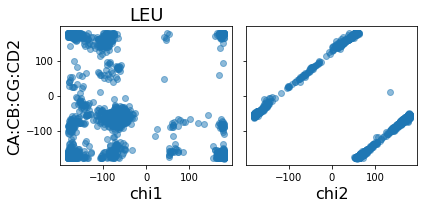

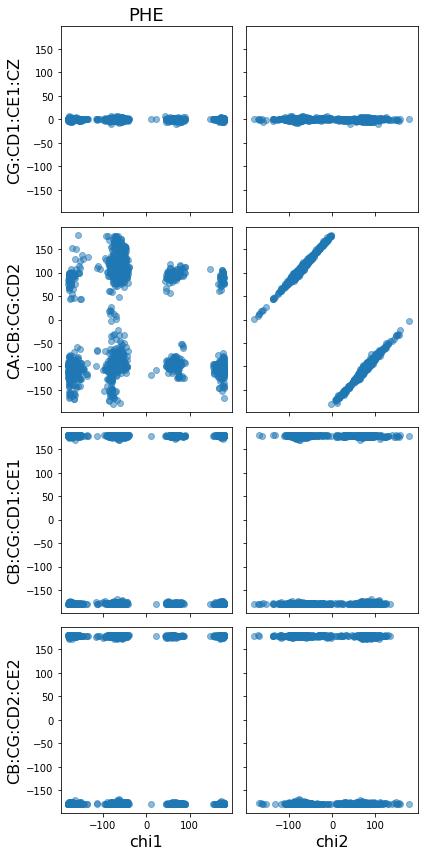

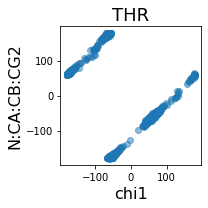

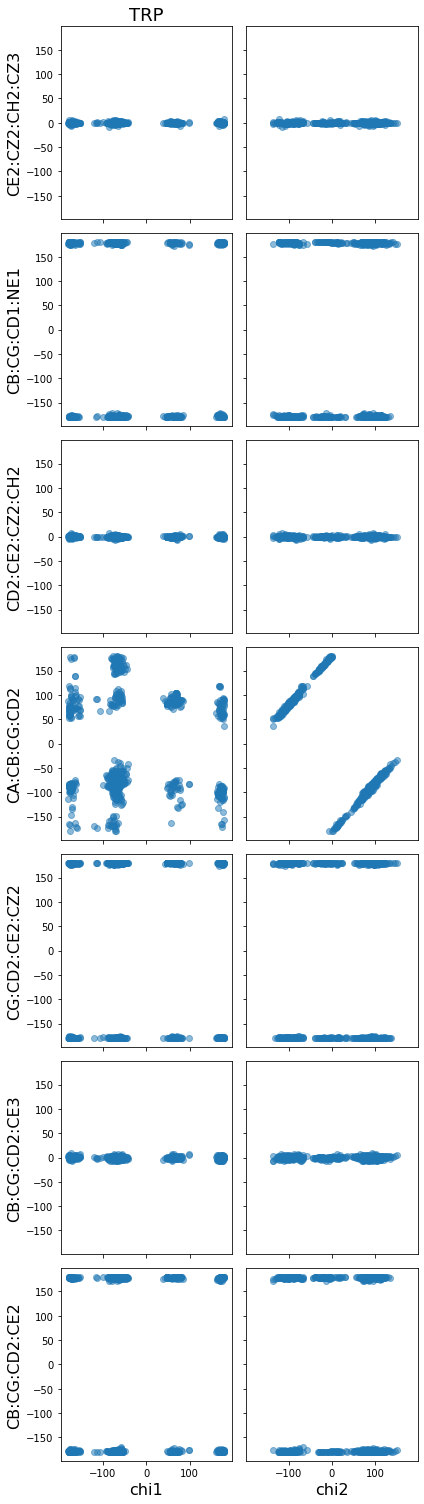

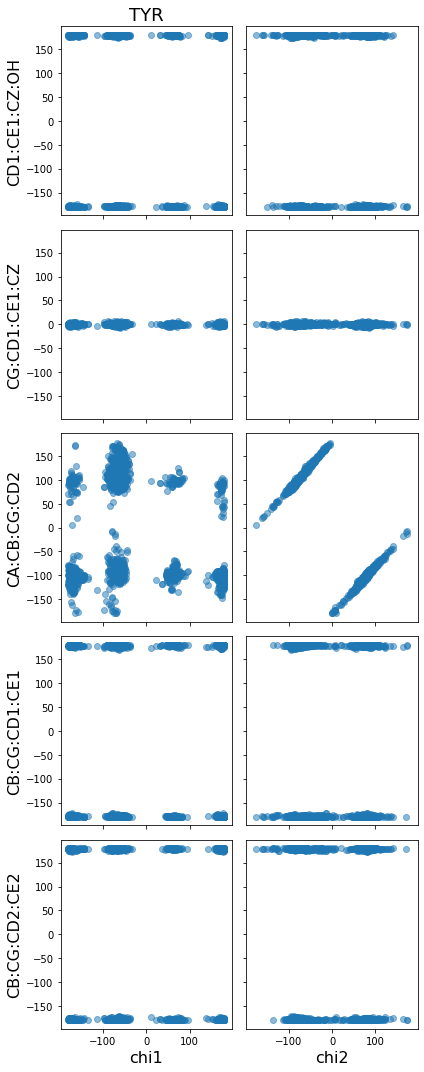

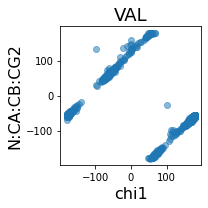

In [98]:
# plot correlations between chi angles and the other dihedrals


import itertools

for aa in internal_coords_atomic_combos_by_resname:
    if aa in {'GLY', 'ALA'}: continue

    atomic_combos = list(filter(lambda x: not is_only_backbone_and_CB(x), internal_coords_atomic_combos_by_resname[aa]))
    dihedral_angles = list(filter(lambda x: len(x.split(':')) == 4, atomic_combos))
    chi_angles = list(filter(lambda x: 'chi' in x, atomic_combos))

    if len(dihedral_angles) == 0 or len(chi_angles) == 0: continue

    ncols = len(chi_angles)
    nrows = len(dihedral_angles)
    colsize = 3
    rowsize = 3
    fig, axs = plt.subplots(figsize=(ncols*colsize, nrows*rowsize), ncols=ncols, nrows=nrows, sharex=True, sharey=True)

    if len(dihedral_angles) + len(chi_angles) == 2:
        axs = [axs]
    else:
        axs = axs.flatten()
    
    for i, ((dihedral_angle, chi_angle), ax) in enumerate(zip(itertools.product(dihedral_angles, chi_angles), axs)):
        ax.scatter(internal_coords_trace[aa][chi_angle], internal_coords_trace[aa][dihedral_angle], alpha=.5)

        if i == 0:
            ax.set_title(aa, fontsize=18)

        if i % ncols == 0:
            ax.set_ylabel(dihedral_angle, fontsize=16)
        
        if i // ncols == nrows - 1:
            ax.set_xlabel(chi_angle, fontsize=16)
    
    plt.tight_layout()
    plt.show()

    # extra plot to verify the symmetry of the dihedrals of Arginine --> confirmed!!!
    if aa == 'ARG':
        plt.scatter(internal_coords_trace[aa][dihedral_angles[0]], internal_coords_trace[aa][dihedral_angles[1]], alpha=.5)
        plt.title(aa, fontsize=18)
        plt.xlabel(dihedral_angles[0], fontsize=16)
        plt.ylabel(dihedral_angles[1], fontsize=16)
        plt.tight_layout()
        plt.show()





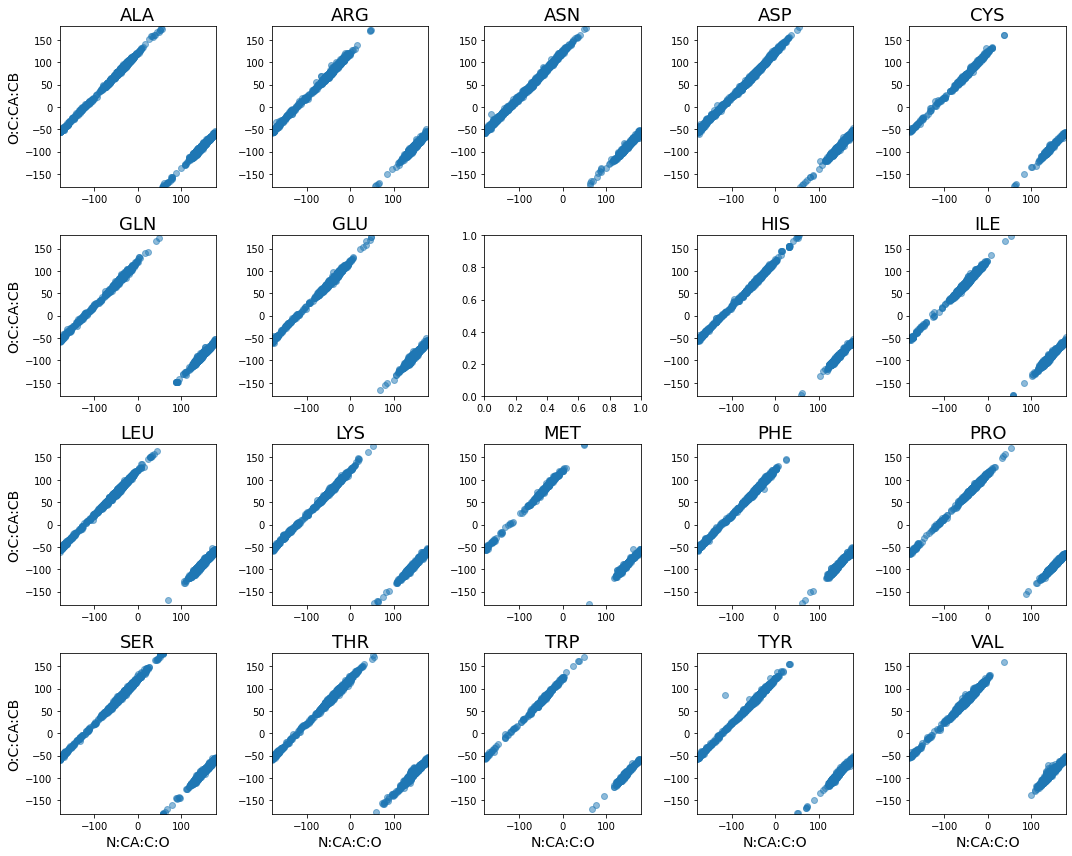

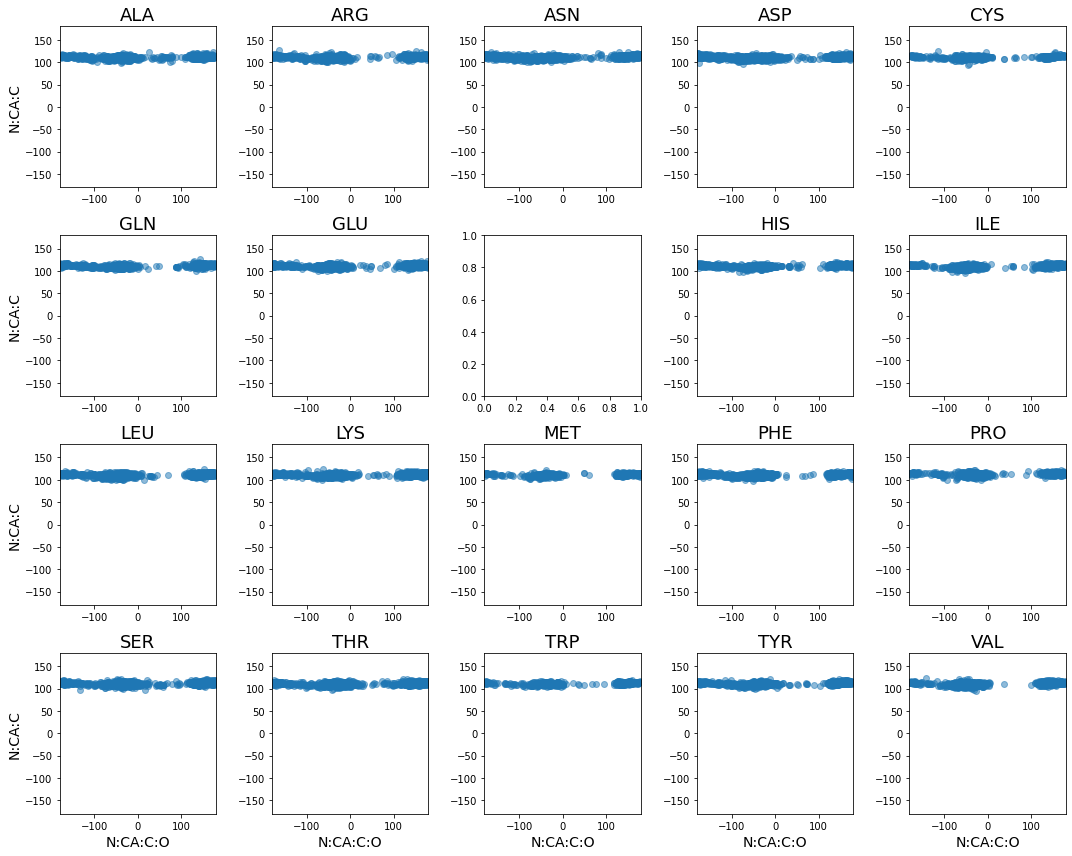

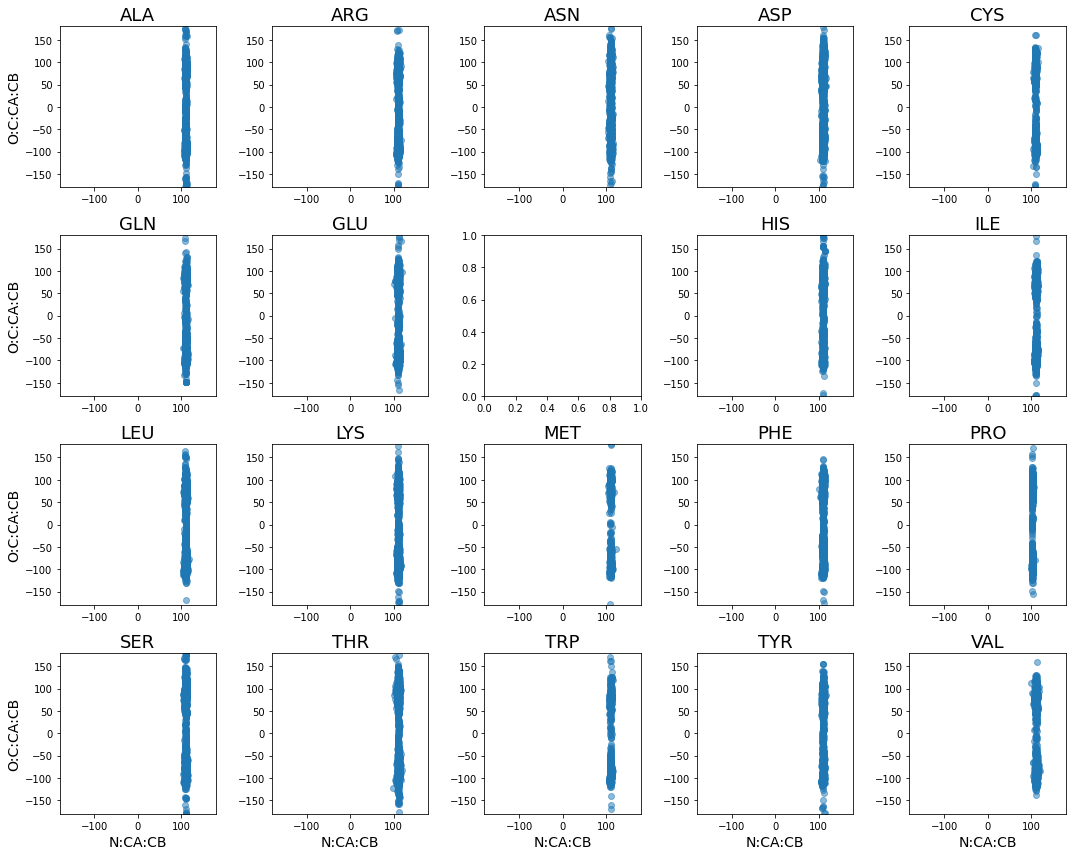

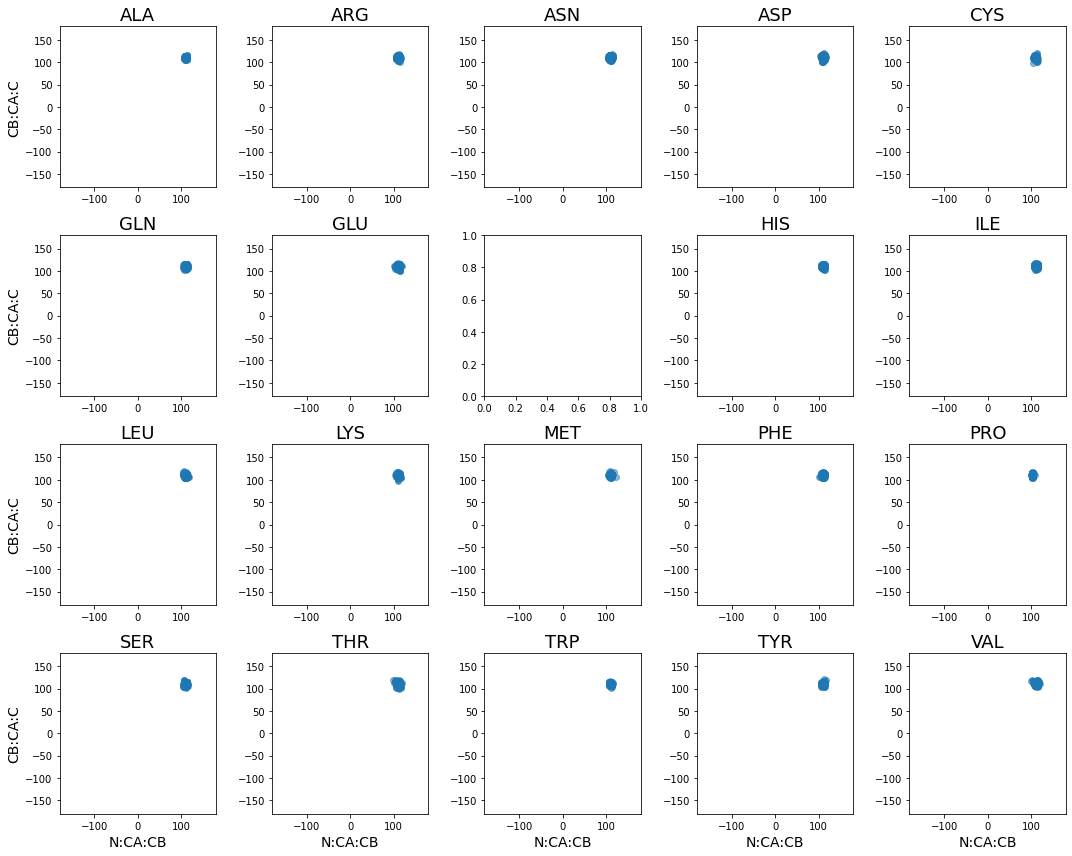

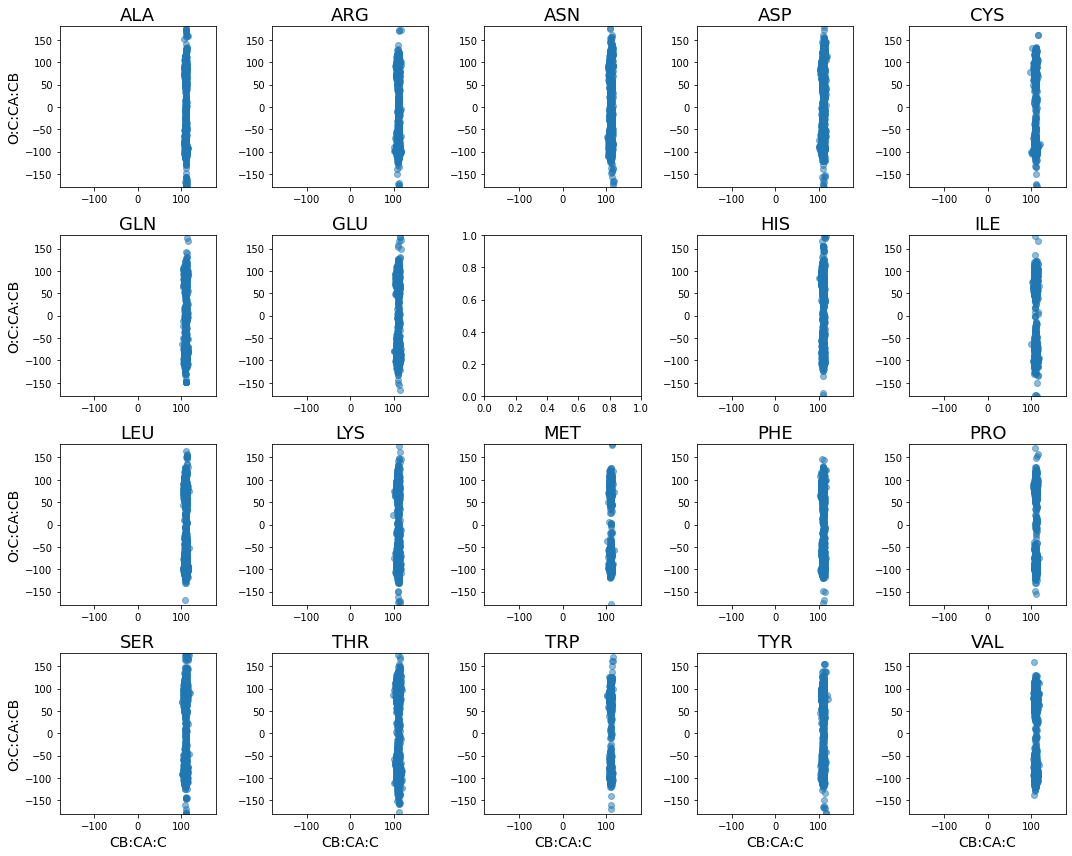

In [83]:
# let's plot the correlation between combos that we think are correlated. namely N:CA:CB with O:C:CA:CB and also with CB:CA:C
# crucially, N:CA:C:O and O:C:CA:CB

def comparison_plot(internal_coords_trace, combo1, combo2):

    ncols = 5
    nrows = 4
    colsize = 3
    rowsize = 3
    fig, axs = plt.subplots(figsize=(ncols*colsize, nrows*rowsize), ncols=ncols, nrows=nrows, sharex=False, sharey=False)

    for i, (aa, ax) in enumerate(zip(internal_coords_trace, axs.flatten())):
        if aa == 'GLY': continue
        ax.scatter(internal_coords_trace[aa][combo1], internal_coords_trace[aa][combo2], alpha=.5)
        ax.set_xlim([-180, 180])
        ax.set_ylim([-180, 180])
        ax.set_title(aa, fontsize=18)

        if i % ncols == 0:
            ax.set_ylabel(combo2, fontsize=14)
        
        if i >= (nrows-1)*ncols:
            ax.set_xlabel(combo1, fontsize=14)

    plt.tight_layout()
    plt.show()

comparison_plot(internal_coords_trace, 'N:CA:C:O', 'O:C:CA:CB') # yes, perfectly correlated
comparison_plot(internal_coords_trace, 'N:CA:C:O', 'N:CA:C')
comparison_plot(internal_coords_trace, 'N:CA:CB', 'O:C:CA:CB') # nope, not correlated, but I thought they were!
comparison_plot(internal_coords_trace, 'N:CA:CB', 'CB:CA:C') # nope, not correlated, but I thought they were!
comparison_plot(internal_coords_trace, 'CB:CA:C', 'O:C:CA:CB') # nope, not correlated, but I thought they were!



In [104]:
# alright! now compute the relationships between dihedrals!

# store a dictionary with the ordered pairs of dihedrals that are related, with the first item being the one we compute (either backbone dihedral or chi-angle)
# dictionary's keys are amino-acids!
# this is a hard-coded dictionary. but then, using data, we augment it with the offset!

RELATED_DIHEDRALS = {
    'ALA' : [('N:CA:C:O', 'O:C:CA:CB')],
    'ARG' : [('N:CA:C:O', 'O:C:CA:CB')],
    'ASN' : [('N:CA:C:O', 'O:C:CA:CB'), ('chi2', 'CA:CB:CG:ND2')],
    'ASP' : [('N:CA:C:O', 'O:C:CA:CB'), ('chi2', 'CA:CB:CG:OD2')],
    'CYS' : [('N:CA:C:O', 'O:C:CA:CB')],
    'GLN' : [('N:CA:C:O', 'O:C:CA:CB'), ('chi3', 'CB:CG:CD:NE2')],
    'GLU' : [('N:CA:C:O', 'O:C:CA:CB'), ('chi3', 'CB:CG:CD:OE2')],
    'HIS' : [('N:CA:C:O', 'O:C:CA:CB'), ('chi2', 'CA:CB:CG:CD2')],
    'ILE' : [('N:CA:C:O', 'O:C:CA:CB'), ('chi1', 'N:CA:CB:CG2')],
    'LEU' : [('N:CA:C:O', 'O:C:CA:CB'), ('chi2', 'CA:CB:CG:CD2')],
    'LYS' : [('N:CA:C:O', 'O:C:CA:CB')],
    'MET' : [('N:CA:C:O', 'O:C:CA:CB')],
    'PHE' : [('N:CA:C:O', 'O:C:CA:CB'), ('chi2', 'CA:CB:CG:CD2')],
    'PRO' : [('N:CA:C:O', 'O:C:CA:CB')],
    'SER' : [('N:CA:C:O', 'O:C:CA:CB')],
    'THR' : [('N:CA:C:O', 'O:C:CA:CB'), ('chi1', 'N:CA:CB:CG2')],
    'TRP' : [('N:CA:C:O', 'O:C:CA:CB'), ('chi2', 'CA:CB:CG:CD2')],
    'TYR' : [('N:CA:C:O', 'O:C:CA:CB'), ('chi2', 'CA:CB:CG:CD2')],
    'VAL' : [('N:CA:C:O', 'O:C:CA:CB'), ('chi1', 'N:CA:CB:CG2')],
}

def plot_distribution_of_difference_between_dihedrals(internal_coords_trace):

    ## plot the distributions first, just to see
    ## NOTE: constant offset for all!

    for aa in RELATED_DIHEDRALS:

        ncols = len(RELATED_DIHEDRALS[aa])
        nrows = 1
        colsize = 4
        rowsize = 3
        fig, axs = plt.subplots(figsize=(ncols*colsize, nrows*rowsize), ncols=ncols, nrows=nrows, sharex=False, sharey=False)

        if len(RELATED_DIHEDRALS[aa]) == 1:
            axs = [axs]
        else:
            axs = axs.flatten()
        
        for i, ((dihedral1, dihedral2), ax) in enumerate(zip(RELATED_DIHEDRALS[aa], axs)):
            diff = np.mod( (np.array(internal_coords_trace[aa][dihedral2]) - np.array(internal_coords_trace[aa][dihedral1])) + 180, 360) - 180

            ax.hist(diff, bins=100, density=True, label=np.median(diff))

            ax.set_xlim([-190, 190])
            ax.set_title(f'{dihedral2} - {dihedral1}', fontsize=18)
            if i == 0: ax.set_ylabel(aa, fontsize=18)
            ax.legend()

        plt.tight_layout()
        plt.show()

def plot_dihedral_reconstruction(internal_coords_trace):

    ## now, need to verify that we can actually recover the values. because modular arithmetic might be fucking us over
    ## if all is well, we expect diagonal lines and corners (the corners are the +180 / -180 boundary which is fine due to periodicity)
    ## NOTE: all is well!!!

    for aa in RELATED_DIHEDRALS:

        ncols = len(RELATED_DIHEDRALS[aa])
        nrows = 1
        colsize = 4
        rowsize = 3
        fig, axs = plt.subplots(figsize=(ncols*colsize, nrows*rowsize), ncols=ncols, nrows=nrows, sharex=False, sharey=False)

        if len(RELATED_DIHEDRALS[aa]) == 1:
            axs = [axs]
        else:
            axs = axs.flatten()
        
        for i, ((dihedral1, dihedral2), ax) in enumerate(zip(RELATED_DIHEDRALS[aa], axs)):
            diff = np.mod( (np.array(internal_coords_trace[aa][dihedral2]) - np.array(internal_coords_trace[aa][dihedral1])) + 180, 360) - 180

            if (np.max(diff) - np.min(diff)) > 355: # +/- 180 case! pick 180
                dihedral_offset = 180.0
            else:
                dihedral_offset = np.median(diff)
            
            reconstructed_dihedral2 = np.mod((np.array(internal_coords_trace[aa][dihedral1]) + dihedral_offset) + 180, 360) - 180

            ax.scatter(np.array(internal_coords_trace[aa][dihedral2]), reconstructed_dihedral2)
            ax.set_xlabel(f'Real {dihedral2}', fontsize=16)
            ax.set_ylabel(f'Rec {dihedral2}', fontsize=16)
            ax.set_xlim([-190, 190])
            ax.set_ylim([-190, 190])
            ax.plot([-190, 190], [-190, 190], color='black', linestyle='--')
            if i == 0: ax.set_title(aa, fontsize=18)
        
        plt.tight_layout()
        plt.show()






In [69]:


# first, let's compute internal coordinates for some residue in a full-atom structure

structure = parser.get_structure("3ct8", "pdbs/3ct8.pdb")

bb_only_structure = remove_all_sidechains(structure)

structure.atom_to_internal_coordinates()

desired_resname = 'ASN'


# problem: they don't use the dihedral 'C:N:CA:CB' for determining the location of CB... but then, what do they use?

for residue in Selection.unfold_entities(structure, 'R'):
    if residue.resname == desired_resname:

        internal_coords = get_internal_coords_from_scratch(residue)
        print(internal_coords)
        print()

        residue.internal_coord.set_angle('chi2', 40)

        break

structure.internal_to_atom_coordinates()
structure.atom_to_internal_coordinates()

for residue in Selection.unfold_entities(structure, 'R'):
    if residue.resname == desired_resname:

        internal_coords = get_internal_coords_from_scratch(residue)
        print(internal_coords)
        print()

        break


# internal_coords = {}

# for residue in Selection.unfold_entities(structure, 'R'):
#     if residue.resname == desired_resname:

#         # residue.internal_coord.set_angle('O:C:CA:CB', 40) # changing this dihedral, changes N:CA:CB !
#         # residue.internal_coord.set_angle('CB:CA:C', 120) # changing this bond angle, changes N:CA:CB !
#         # residue.internal_coord.set_angle('N:CA:CB', 120) # the change in this bond angle actually gets nullified by the subsequent calls to .internal_to_atom_coordinates() and .atom_to_internal_coordinates() ! --> it's just clear that this bond angle is redundant given the other information

#         # residue.internal_coord.set_angle('N:CA:CB:CG1', 40) # changing this, doesn't change anything else (for VAL!)
#         # residue.internal_coord.set_angle('N:CA:CB:CG2', 40) # changing this, doesn't change anything else! (for VAL!) I'm a bit surprised, maybe it's just constant

#         # residue.internal_coord.set_angle('CA:CB:CG1', 40) # changing this, doesn't change anything else (for VAL!)
#         # residue.internal_coord.set_angle('CA:CB:CG2', 40) # changing this, doesn't change anything else (for VAL!)

#         structure.internal_to_atom_coordinates()
#         structure.atom_to_internal_coordinates()
#         internal_coords_after = get_internal_coords(residue)

#         break

# print(internal_coords_after)
# print()


# chi angle ['N', 'CA', 'CB', 'CG'] not found in 3ty4.pdb for LYS
# chi angle ['CA', 'CB', 'CG', 'CD'] not found in 3ty4.pdb for LYS
# chi angle ['CB', 'CG', 'CD', 'CE'] not found in 3ty4.pdb for LYS
# chi angle ['CG', 'CD', 'CE', 'NZ'] not found in 3ty4.pdb for LYS

{'C:CA': 1.5220928243956393, 'C:O': 1.2262881842695144, 'CA:N': 1.494279305587838, 'CA:CB': 1.532694044345914, 'CB:CG': 1.523247657613129, 'CG:ND2': 1.334663906552965, 'CG:OD1': 1.2327303868012198, 'N:CA:C': 113.4991494291486, 'CA:C:O': 121.544111990183, 'CB:CA:C': 111.57364159602676, 'N:CA:CB': 110.78963426974427, 'CA:CB:CG': 112.41964503756363, 'CB:CG:ND2': 116.84231820329275, 'CB:CG:OD1': 120.57347588398999, 'N:CA:C:O': -41.815384620841954, 'O:C:CA:CB': 84.20750606412248, 'CA:CB:CG:ND2': 145.22504580110268, 'chi1': -74.61647207420849, 'chi2': -37.57538687542174}

{'C:CA': 1.5220928243956393, 'C:O': 1.2262881842695144, 'CA:N': 1.494279305587838, 'CA:CB': 1.532694044345914, 'CB:CG': 1.523247657613129, 'CG:ND2': 1.334663906552965, 'CG:OD1': 1.2327303868012245, 'N:CA:C': 113.4991494291486, 'CA:C:O': 121.544111990183, 'CB:CA:C': 111.57364159602676, 'N:CA:CB': 110.78963426974427, 'CA:CB:CG': 112.41964503756363, 'CB:CG:ND2': 116.84231820329275, 'CB:CG:OD1': 120.57347588398984, 'N:CA:C:O': 

In [40]:
def test_chi_angles_names_in_biopython_internal_coords():
    import os
    from Bio.PDB import PDBParser
    
    pdbs = os.listdir('pdbs')

    parser = PDBParser()

    used_residues = set()

    i = 0
    while len(used_residues) < 18:

        pdb = pdbs[i]
        structure = parser.get_structure(pdb, f"pdbs/{pdb}")
        structure.atom_to_internal_coordinates()

        for residue in Selection.unfold_entities(structure, 'R'):
            if residue.resname in CHI_ANGLES and residue.resname not in used_residues:
                for chi_angle_atoms in CHI_ANGLES[residue.resname]:
                    for perm in all_permutations(':'.join(chi_angle_atoms)):
                        if residue.internal_coord.get_angle(perm) is not None:
                            break
                    else:
                        print(f"chi angle {chi_angle_atoms} not found in {pdb} for {residue.resname}")
                        print(list(residue.get_atoms()))
                
                used_residues.add(residue.resname)
        
        i += 1

test_chi_angles_names_in_biopython_internal_coords()

'''

Sometimes the internal coords will return only backbone atoms... and no sidechain atoms. idk why. but for our purposes it doesn't really matter

'''


0
chi angle ['N', 'CA', 'CB', 'CG'] not found in 1obz.pdb for ASP
[<Atom N>, <Atom CA>, <Atom C>, <Atom O>, <Atom CB>]
chi angle ['CA', 'CB', 'CG', 'OD1'] not found in 1obz.pdb for ASP
[<Atom N>, <Atom CA>, <Atom C>, <Atom O>, <Atom CB>]
17


"\n\nSometimes the internal coords will return only backbone atoms... and no sidechain atoms. idk why. but for our purposes it doesn't really matter\n\n"

In [ ]:
# 

Bakcbone: it looks like we can ski keeping track of 'N:CA:CB', since its values are dependent upon other internal coords.

VAL:
    - it looks like all information is non-redundant